In [32]:
# import libraries
from platform import python_version
print(python_version())
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 8}
import matplotlib as mpl

from scipy.signal import butter, lfilter, freqz

plt.rc('font', **font)

%run ./scripts/util_func.py
%run ./scripts/model_func.py

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)
plt.rc('axes', labelsize=9)
mpl.rcParams['lines.dashed_pattern'] = [2, 2]
mpl.rcParams['lines.linewidth'] = 1.0

3.6.9


In [232]:
# import data

test_path = './data/powertrain_analysis/left_right_from_idle_1/'

# to remove last n rows due to estop
n_rows_delete = 0

left_wheel_cmd_df = pd.read_csv(test_path + "_slash_left_drive_slash_velocity.csv", skiprows=[1])
left_wheel_cmd_df.drop(left_wheel_cmd_df.tail(n_rows_delete).index, inplace = True)
left_wheel_cmd_df.to_pickle('./data/powertrain_analysis/pickle/left_right_from_idle_1/left_cmd.pk1')
right_wheel_cmd_df = pd.read_csv(test_path + "_slash_right_drive_slash_velocity.csv", skiprows=[1])
right_wheel_cmd_df.drop(right_wheel_cmd_df.tail(n_rows_delete).index, inplace = True)
right_wheel_cmd_df.to_pickle('./data/powertrain_analysis/pickle/left_right_from_idle_1/right_cmd.pk1')

left_wheel_meas_df = pd.read_csv(test_path + "_slash_left_drive_slash_status_slash_speed.csv", skiprows=[1])
# left_wheel_meas_df.drop(left_wheel_meas_df.tail(int(n_rows_delete/5)).index, inplace = True)
left_wheel_meas_df.to_pickle('./data/powertrain_analysis/pickle/left_right_from_idle_1/left_meas.pk1')
right_wheel_meas_df = pd.read_csv(test_path + "_slash_right_drive_slash_status_slash_speed.csv", skiprows=[1])
right_wheel_meas_df.to_pickle('./data/powertrain_analysis/pickle/left_right_from_idle_1/right_meas.pk1')
# right_wheel_meas_df.drop(right_wheel_meas_df.tail(int(n_rows_delete/5)).index, inplace = True)

print(left_wheel_cmd_df)

          rosbagTimestamp  data
0     1655755895461980160   0.0
1     1655755895462004781   0.0
2     1655755895462134169   0.0
3     1655755895462258804   0.0
4     1655755895462356802   0.0
...                   ...   ...
2832  1655756036845040468   0.0
2833  1655756036895001812   0.0
2834  1655756036945227456   0.0
2835  1655756036995534370   0.0
2836  1655756037045071222   0.0

[2837 rows x 2 columns]


In [212]:
# convert to numpy arrays

def set_time_to_zero_seconds(array):
    time_init = array[0,0]
    array[:, 0] = (array[:, 0] - time_init) * 10 ** (-9)
    return array

left_wheel_cmd = left_wheel_cmd_df.to_numpy()
left_wheel_cmd = set_time_to_zero_seconds(left_wheel_cmd)
right_wheel_cmd = right_wheel_cmd_df.to_numpy()
right_wheel_cmd = set_time_to_zero_seconds(right_wheel_cmd)

left_wheel_meas = left_wheel_meas_df.to_numpy()
left_wheel_meas = set_time_to_zero_seconds(left_wheel_meas)
right_wheel_meas = right_wheel_meas_df.to_numpy()
right_wheel_meas = set_time_to_zero_seconds(right_wheel_meas)

print(left_wheel_cmd.shape)
print(left_wheel_meas.shape)

print(left_wheel_cmd[:, 0])

(7212, 2)
(1426, 2)
[0.00000000e+00 2.91584000e-04 3.46624000e-04 ... 3.60245087e+02
 3.60294988e+02 3.60345133e+02]


In [214]:
# fit powertrain model

tau_c = 2.0
tau_d = 0.0

start_offset = 10
rate = 20

def powertrain_vel(time_id, cmd_array, last_vel, tau_c, tau_d, rate):
    next_vel = last_vel + (1/tau_c) * (cmd_array[int(time_id - rate * tau_d), 1] - last_vel) * (1/rate)
    return next_vel

def compute_model_wheel_vels(cmd_array, tau_c, tau_d, rate, start_offset):
    model_array = np.zeros((cmd_array.shape[0], 2))
    model_array[:, 0] = cmd_array[:, 0]

    for i in range(start_offset, cmd_array.shape[0]):
        model_array[i, 1] = powertrain_vel(i, cmd_array, model_array[i-1, 1], tau_c, tau_d, rate)
        
    return model_array
        
left_wheel_model = compute_model_wheel_vels(left_wheel_cmd, tau_c, tau_d, rate, start_offset)
right_wheel_model = compute_model_wheel_vels(right_wheel_cmd, tau_c, tau_d, rate, start_offset)

In [227]:
# compute error tolerance arrays for steady_state

cmd_error_tolerance = 0.1

def compute_error_tol_wheel_vels(cmd_array, model cmd_error_tolerance):
    error_array = np.zeros((cmd_array.shape[0], 3))
    error_array[:, 0] = cmd_array[:, 0]

    for i in range(0, cmd_array.shape[0]):
        error_array[i, 1] = cmd_array[i, 1] + cmd_error_tolerance
        error_array[i, 2] = cmd_array[i, 1] - cmd_error_tolerance
        
    return error_array

left_wheel_error_tol = compute_error_tol_wheel_vels(left_wheel_cmd, cmd_error_tolerance)
right_wheel_error_tol = compute_error_tol_wheel_vels(right_wheel_cmd, cmd_error_tolerance)

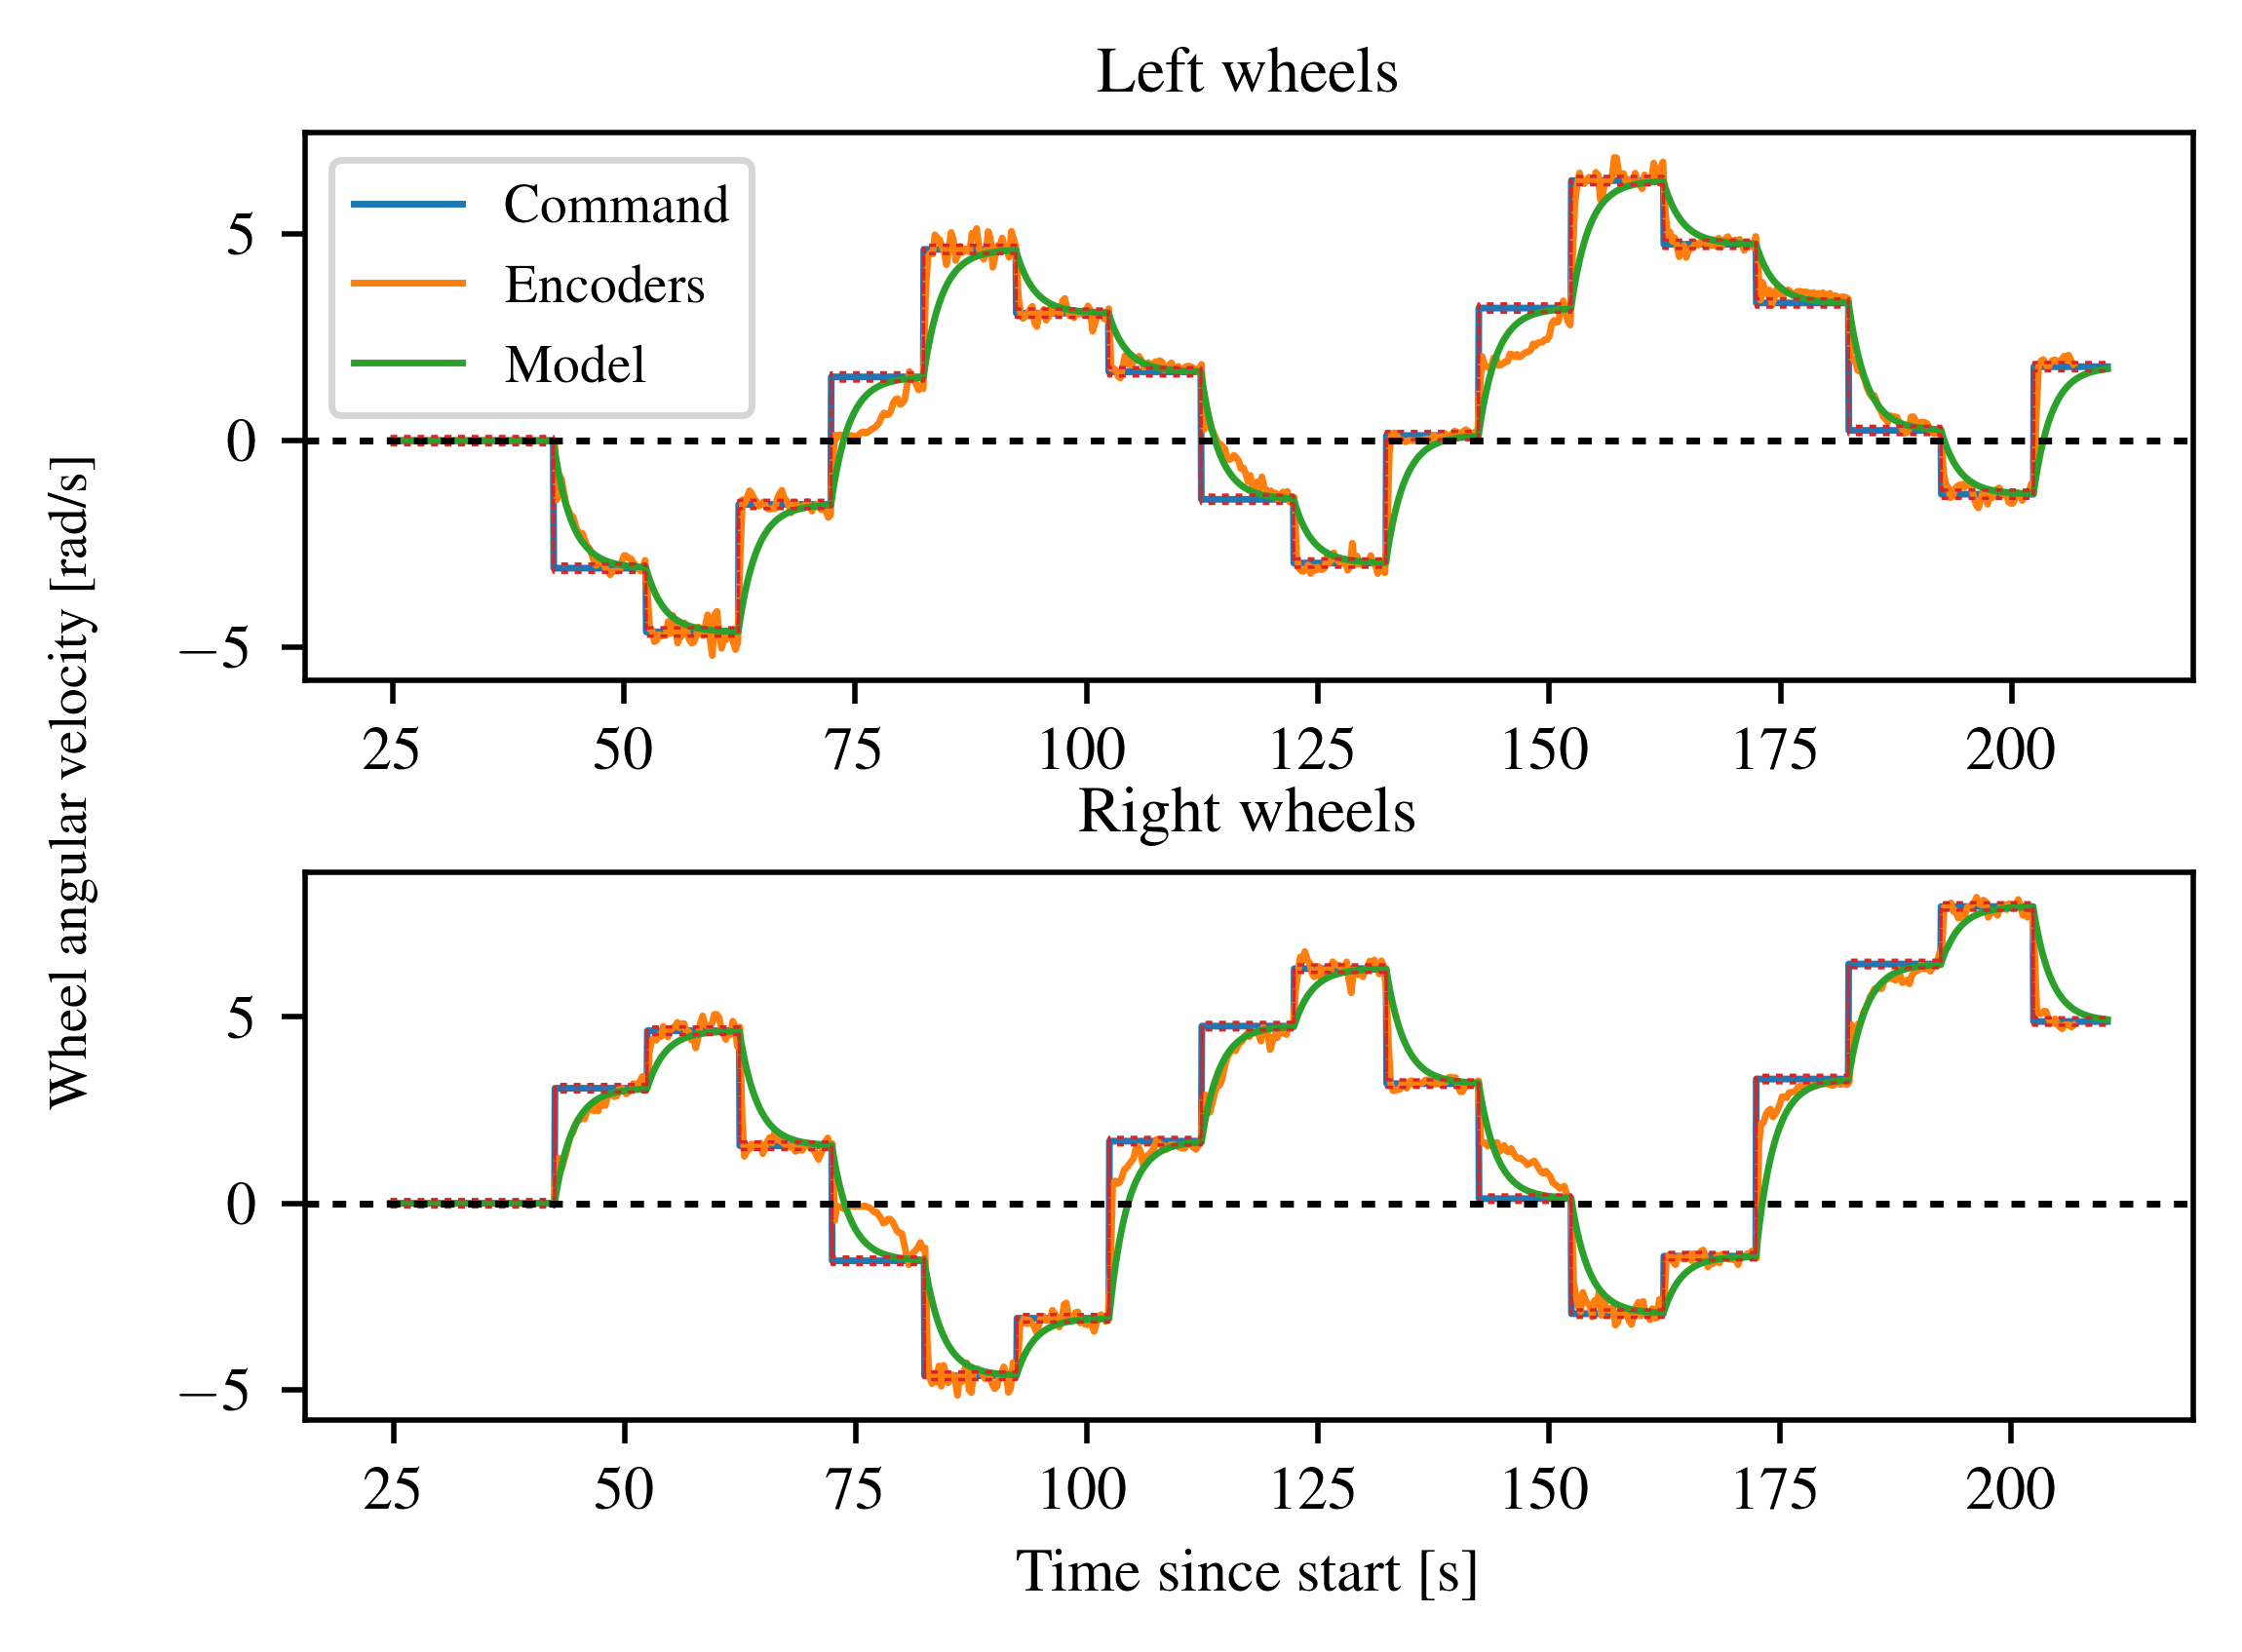

In [231]:
# plot wheel vels cmd vs measured

index_start = 500
index_end = 3000

width  = 2.5
height = 3.5

fig, axs = plt.subplots(2, 1, dpi=500, gridspec_kw={'hspace': 0.35, 'wspace': 0.23})
fig.set_size_inches(2*width, height)
# fig.subplots_adjust(left=.11, bottom=.18, right=.99, top=.97)


# right side
axs[0].plot(left_wheel_cmd[index_start:-index_end, 0], left_wheel_cmd[index_start:-index_end, 1], linestyle='-', markersize=0.5, c='C0', label='Command')
axs[0].plot(left_wheel_meas[int(index_start/5):int(-index_end/5), 0], left_wheel_meas[int(index_start/5):int(-index_end/5), 1], linestyle='-', markersize=0.5, c='C1', label='Encoders')
axs[0].plot(left_wheel_model[index_start:-index_end, 0], left_wheel_model[index_start:-index_end, 1], linestyle='-', markersize=0.5, c='C2', label='Model')
axs[0].plot(left_wheel_error_tol[index_start:-index_end, 0], left_wheel_error_tol[index_start:-index_end, 1], linestyle='--', linewidth=0.5, markersize=0.5, c='C3')
axs[0].plot(left_wheel_error_tol[index_start:-index_end, 0], left_wheel_error_tol[index_start:-index_end, 2], linestyle='--', linewidth=0.5, markersize=0.5, c='C3')
axs[0].axhline(0, linestyle='--', c='k')

axs[1].plot(right_wheel_cmd[index_start:-index_end, 0], right_wheel_cmd[index_start:-index_end, 1], linestyle='-', markersize=0.5, c='C0')
axs[1].plot(right_wheel_meas[int(index_start/5):int(-index_end/5), 0], right_wheel_meas[int(index_start/5):int(-index_end/5), 1], linestyle='-', markersize=0.5, c='C1')
axs[1].plot(right_wheel_model[index_start:-index_end, 0], right_wheel_model[index_start:-index_end, 1], linestyle='-', markersize=0.5, c='C2')
axs[1].plot(right_wheel_error_tol[index_start:-index_end, 0], right_wheel_error_tol[index_start:-index_end, 1], linestyle='--', linewidth=0.5, markersize=0.5, c='C3')
axs[1].plot(right_wheel_error_tol[index_start:-index_end, 0], right_wheel_error_tol[index_start:-index_end, 2], linestyle='--', linewidth=0.5, markersize=0.5, c='C3')
axs[1].axhline(0, linestyle='--', c='k')

axs[0].set_title('Left wheels')
axs[1].set_title('Right wheels')

axs[0].legend(loc = 'upper left')

axs[1].set_xlabel('Time since start [s]')

fig.text(0.02, 0.5, 'Wheel angular velocity [rad/s]', va='center', rotation='vertical')

plt.savefig('figs/powertrain_encoders_cmd.jpg')